In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
p_nw = []
p_net_nw = []
loss_nw = []
loss_net_nw = []
bool_nw = []

for network_name in ["Random_ER", "Random_SF", "ChIP_hTFtarget", "ChIP_TIP", "ChIP_TIP_K562", "CoExpr_perturb_0.5", "CoExpr_GTEx_WholeBlood_0.75", "CoExpr_ENCODE_K562_0.75", "BIOGRID", "STRING", "Combine", "NOTEARS_thresholdAdaptive", "DAGMA_thresholdAdaptive"]:
    
    # measurements across 10 random sample split
    p_rs = []
    p_net_rs = []
    loss_rs = []
    loss_net_rs = []
    bool_rs = []
    
    for rs in range(10):
        # read data
        X_train = pd.read_csv("../../result/input_perturb_expression/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
        X_valid = pd.read_csv("../../result/input_perturb_expression/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
        X_test = pd.read_csv("../../result/input_perturb_expression/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
        Y_test = pd.read_csv("../../result/input_perturb_expression/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1) * 1000
        Y_test_gene = pd.read_csv("../../result/input_perturb_expression/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

        test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_perturb_phyloP/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = pd.read_csv("../../result/network_perturb_phyloP/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        test_inDAG = Y_test_gene.isin(dag_genes)

        # measurements across 10 random init repeats
        p_rep = []
        p_net_rep = []
        loss_rep = []
        loss_net_rep = []

        for rep in range(10):
            prefix = "../../result/model_perturb_expression/%s/%d/model%d" % (network_name, rs, rep)
            with open(prefix+".para", "rb") as f:
                best_params, X1, out, loss1, loss2 = pickle.load(f)
            Y_pred = out[test_mask].reshape(-1)

            loss_rep.append(F.mse_loss(torch.tensor(Y_test), torch.tensor(Y_pred)).item())
            loss_net_rep.append(F.mse_loss(torch.tensor(Y_test[test_inDAG]), torch.tensor(Y_pred[test_inDAG])).item())
            p_rep.append(pearsonr(Y_test, Y_pred)[0])
            p_net_rep.append(pearsonr(Y_test[test_inDAG], Y_pred[test_inDAG])[0])
        bool_rep = ~np.isnan(np.array(p_net_rep))

        p_rs.append(p_rep)
        p_net_rs.append(p_net_rep)
        loss_rs.append(loss_rep)
        loss_net_rs.append(loss_net_rep)
        bool_rs.append(bool_rep)
        
    p_nw.append(p_rs)
    p_net_nw.append(p_net_rs)
    loss_nw.append(loss_rs)
    loss_net_nw.append(loss_net_rs)
    bool_nw.append(bool_rs)

/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [3]:
p_nw = np.array(p_nw)
p_net_nw = np.array(p_net_nw)
loss_nw = np.array(loss_nw)
loss_net_nw = np.array(loss_net_nw)
bool_nw = np.array(bool_nw)

### all genes

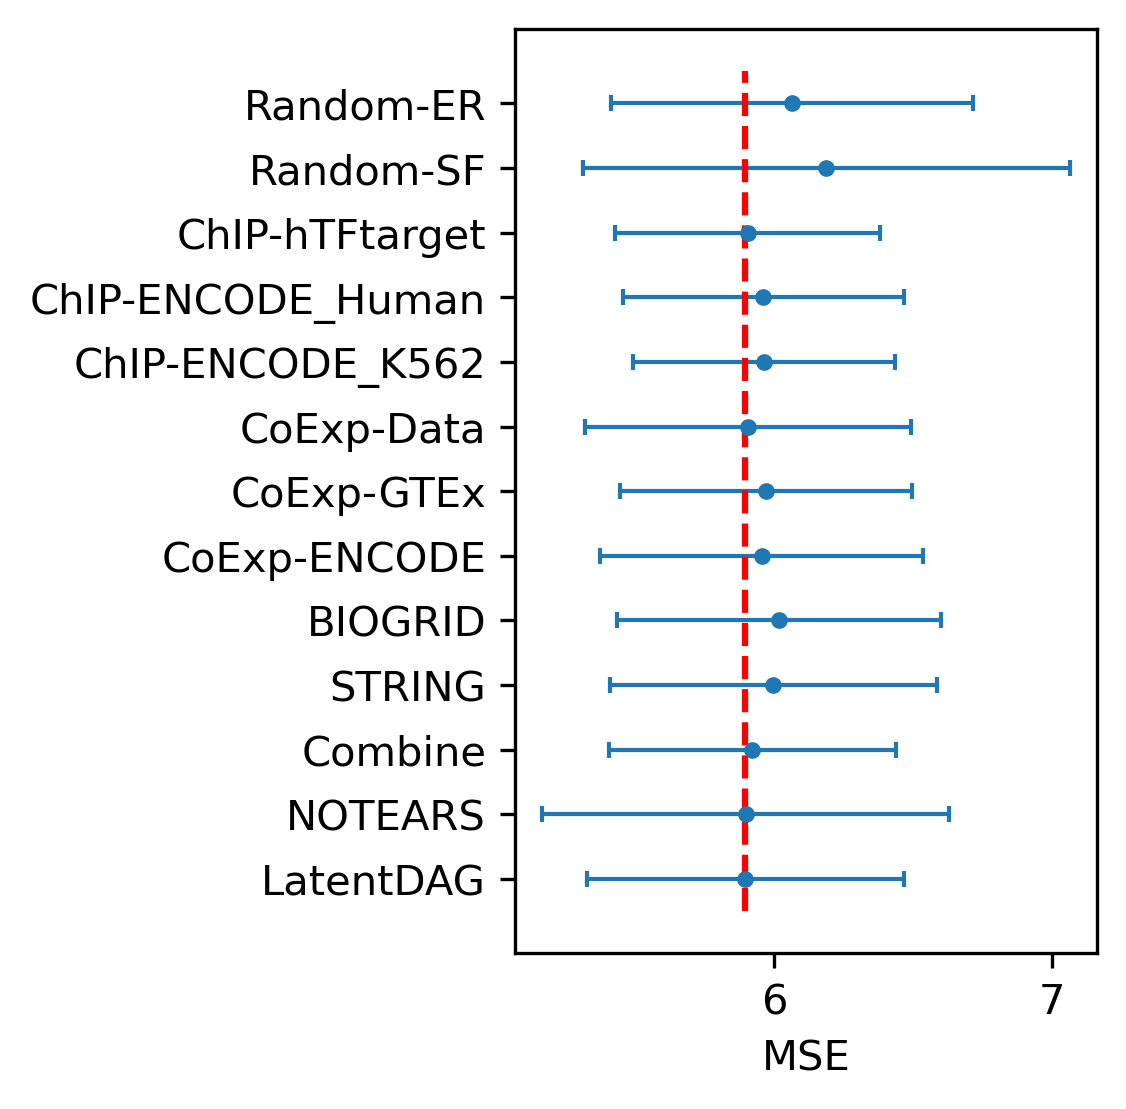

In [4]:
mean_mse = []
std_mse = []
for ii in range(13):
    val = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    val = val[val<10]
    mean_mse.append(val.mean())
    std_mse.append(val.std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine","NOTEARS", "LatentDAG"][::-1])
ax.set_xlabel("MSE")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./expression_mse.pdf", dpi="figure", bbox_inches="tight")

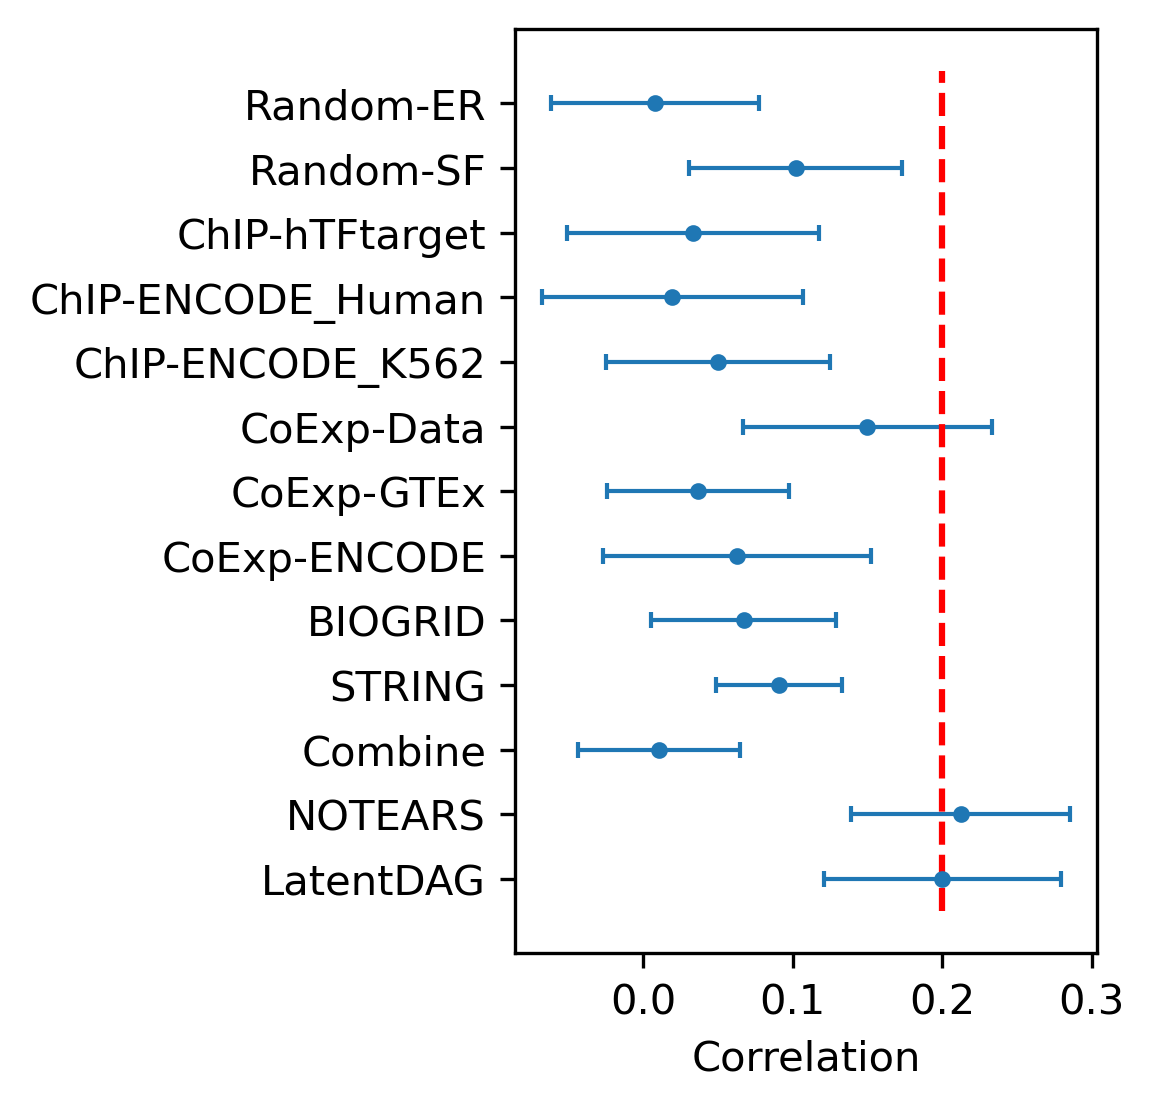

In [5]:
mean_mse = []
std_mse = []
for ii in range(13):
    mean_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine","NOTEARS", "LatentDAG"][::-1])
ax.set_xlabel("Correlation")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./expression_p.pdf", dpi="figure", bbox_inches="tight")

### significance

In [6]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind_from_stats

In [7]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=1.8988142511764208, pvalue=0.05912986954309328)
Ttest_indResult(statistic=2.7529920032748225, pvalue=0.0065622488410424645)
Ttest_indResult(statistic=0.10153412647128, pvalue=0.9192335033209825)
Ttest_indResult(statistic=0.837766528650253, pvalue=0.4031956889932128)
Ttest_indResult(statistic=0.8873196570529511, pvalue=0.3760255362378443)
Ttest_indResult(statistic=1.006548153268494, pvalue=0.3165848014399153)
Ttest_indResult(statistic=0.9670962067228391, pvalue=0.334692336020176)
Ttest_indResult(statistic=0.7054116917426666, pvalue=0.4813880187280051)
Ttest_indResult(statistic=1.4681065436000165, pvalue=0.14368093143233282)
Ttest_indResult(statistic=1.224004191330515, pvalue=0.22240642156330515)
Ttest_indResult(statistic=0.32518373115846794, pvalue=0.7453899236707857)
Ttest_indResult(statistic=0.006855594207536484, pvalue=0.9945373896762106)


In [8]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=1.6748505486127603, pvalue=0.09559065670905842)
Ttest_indResult(statistic=2.51668126747173, pvalue=0.01267957225437219)
Ttest_indResult(statistic=0.07936204726653838, pvalue=0.9368373109675758)
Ttest_indResult(statistic=0.7111583266616798, pvalue=0.4779264973309022)
Ttest_indResult(statistic=0.7467381027921156, pvalue=0.45625763600818336)
Ttest_indResult(statistic=1.0024018268208739, pvalue=0.31854347719329834)
Ttest_indResult(statistic=0.8253684404167974, pvalue=0.4102576406637538)
Ttest_indResult(statistic=0.6075496663682318, pvalue=0.5442192340009478)
Ttest_indResult(statistic=1.2729010949418154, pvalue=0.20462524395300907)
Ttest_indResult(statistic=1.0600265172713883, pvalue=0.29048496797037704)
Ttest_indResult(statistic=0.272026984548482, pvalue=0.7859168619077439)
Ttest_indResult(statistic=0.0, pvalue=1.0)


###### pearson

In [9]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-17.913082984388545, pvalue=8.08470075893529e-43)
Ttest_indResult(statistic=-9.120805374591349, pvalue=9.444438636937996e-17)
Ttest_indResult(statistic=-14.141911003818594, pvalue=1.6198563305398346e-31)
Ttest_indResult(statistic=-15.103026795113268, pvalue=1.7800049042009792e-34)
Ttest_indResult(statistic=-13.59972797290373, pvalue=4.3165541767841394e-30)
Ttest_indResult(statistic=-4.314977354308633, pvalue=2.5284444963601735e-05)
Ttest_indResult(statistic=-16.192413553526745, pvalue=2.4756259268499533e-37)
Ttest_indResult(statistic=-11.35778764846895, pvalue=3.071523215169408e-23)
Ttest_indResult(statistic=-13.099455685528644, pvalue=3.1369102462638577e-28)
Ttest_indResult(statistic=-12.12403712673637, pvalue=5.004672624672504e-24)
Ttest_indResult(statistic=-19.580053194064295, pvalue=5.235647059255313e-46)
Ttest_indResult(statistic=1.139564606042572, pvalue=0.2558532938240503)


In [10]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-19.897216559370957, pvalue=1.2336546039125961e-48)
Ttest_indResult(statistic=-10.716250513608717, pvalue=2.191963238413028e-21)
Ttest_indResult(statistic=-15.732628168588201, pvalue=5.010950574892925e-36)
Ttest_indResult(statistic=-16.6965167725661, pvalue=6.478164013139632e-39)
Ttest_indResult(statistic=-15.32754349185305, pvalue=2.3735284871626537e-35)
Ttest_indResult(statistic=-5.578478549932441, pvalue=8.112782661007215e-08)
Ttest_indResult(statistic=-18.285515431179352, pvalue=7.778430135349781e-44)
Ttest_indResult(statistic=-12.803797545480617, pvalue=2.0321993489770476e-27)
Ttest_indResult(statistic=-15.021596446949085, pvalue=3.129723839443826e-34)
Ttest_indResult(statistic=-14.35324644340382, pvalue=2.027996133080662e-30)
Ttest_indResult(statistic=-21.992116739239936, pvalue=3.03509586265494e-53)
Ttest_indResult(statistic=0.0, pvalue=1.0)
